In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

#Unzip the dataset
import zipfile
zip_ref = zipfile.ZipFile('/content/a-large-scale-fish-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.24G/3.24G [00:53<00:00, 60.2MB/s]
100% 3.24G/3.24G [00:53<00:00, 65.6MB/s]


In [3]:
import os
path = '/content/Fish_Dataset/Fish_Dataset'
fish_dirs = [dir for dir in os.listdir(path) if os.path.isdir(os.path.join(path, dir))]
fish_dirs

['Black Sea Sprat',
 'Trout',
 'Red Mullet',
 'Gilt-Head Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Red Sea Bream',
 'Hourse Mackerel']

Load and Mask Image

In [4]:
def load_image(path, output=False):
    img = cv2.imread(path)
    return np.array(img)

In [5]:
def load_mask(path, output=False):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return np.array(img).reshape(img.shape[0], img.shape[1], 1)

In [8]:
import numpy as np
import cv2
from tqdm import tqdm
for dir in tqdm(fish_dirs):
    p = os.path.join(path, dir, dir)
    images = np.array([load_image(os.path.join(path, dir, dir, img)) for img in os.listdir(p)])
    masks = np.array([load_mask(os.path.join(path, dir, dir + " GT", img), output=True) for img in os.listdir(p)])

100%|██████████| 9/9 [01:22<00:00,  9.14s/it]


In [9]:
nr_tests = 300
images_train, images_test = images[:len(images)-nr_tests], images[len(images)-nr_tests:]
masks_train, masks_test = masks[:len(images)-nr_tests], masks[len(images)-nr_tests:]

dataset = {}
dataset['train'] = {'image':images_train, 'segmentation_mask':masks_train}
dataset['test'] = {'image':images_test, 'segmentation_mask':masks_test}

Normalize and Load Functions

In [10]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask

In [12]:
import tensorflow as tf
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [13]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices(dataset['train'])
test_ds = tf.data.Dataset.from_tensor_slices(dataset['test'])

In [15]:
train = train_ds.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = test_ds.map(load_image_test)

In [16]:
TRAIN_LENGTH = len(train)
BATCH_SIZE = 64
BUFFER_SIZE = 300
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [17]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [20]:
import matplotlib.pyplot as plt
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

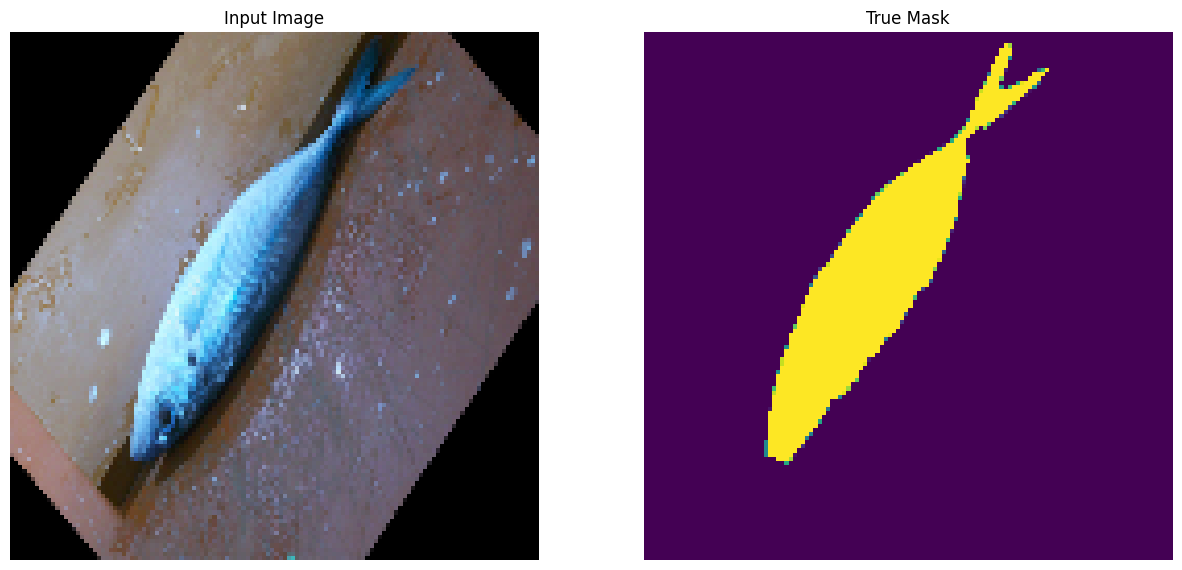

In [21]:
for image, mask in train.take(3):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [22]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [25]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.1 MB/s eta 0:00:00


In [26]:
import tensorflow as tf
import tensorflow_addons as tfa

# Define the pix2pix upsample function if not already provided by TensorFlow
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [27]:


def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [28]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [29]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [30]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 4s 4s/step


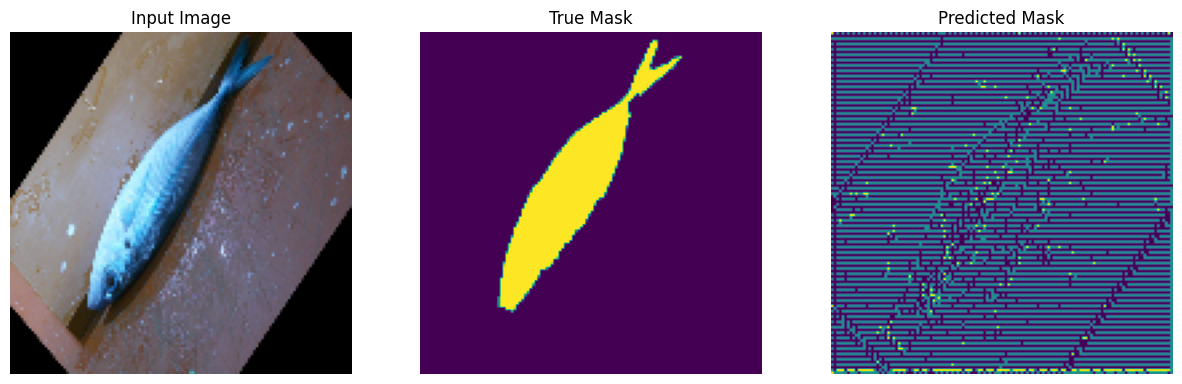

In [32]:
show_predictions(num=6)

In [33]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 23ms/step


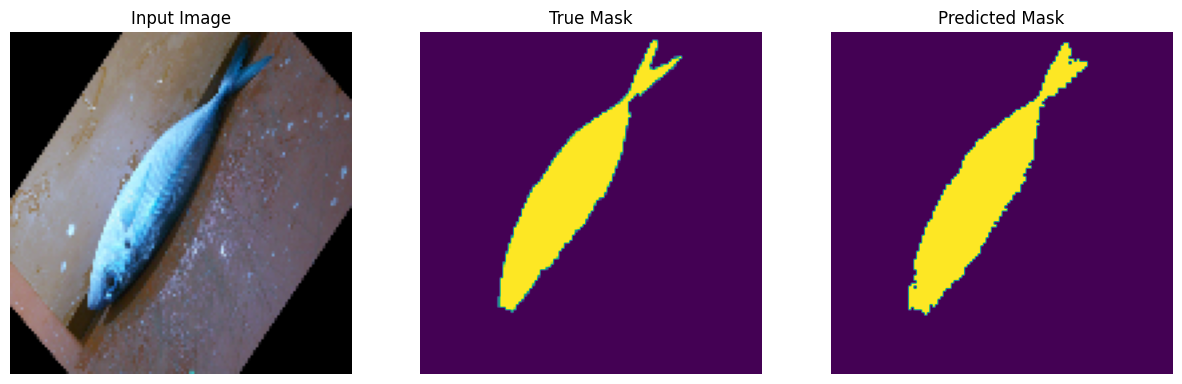


Sample Prediction after epoch 10

10/10 [==============================] - 2s 164ms/step - loss: 0.0272 - accuracy: 0.9870


In [37]:
EPOCHS = 10
VALIDATION_STEPS = 10

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

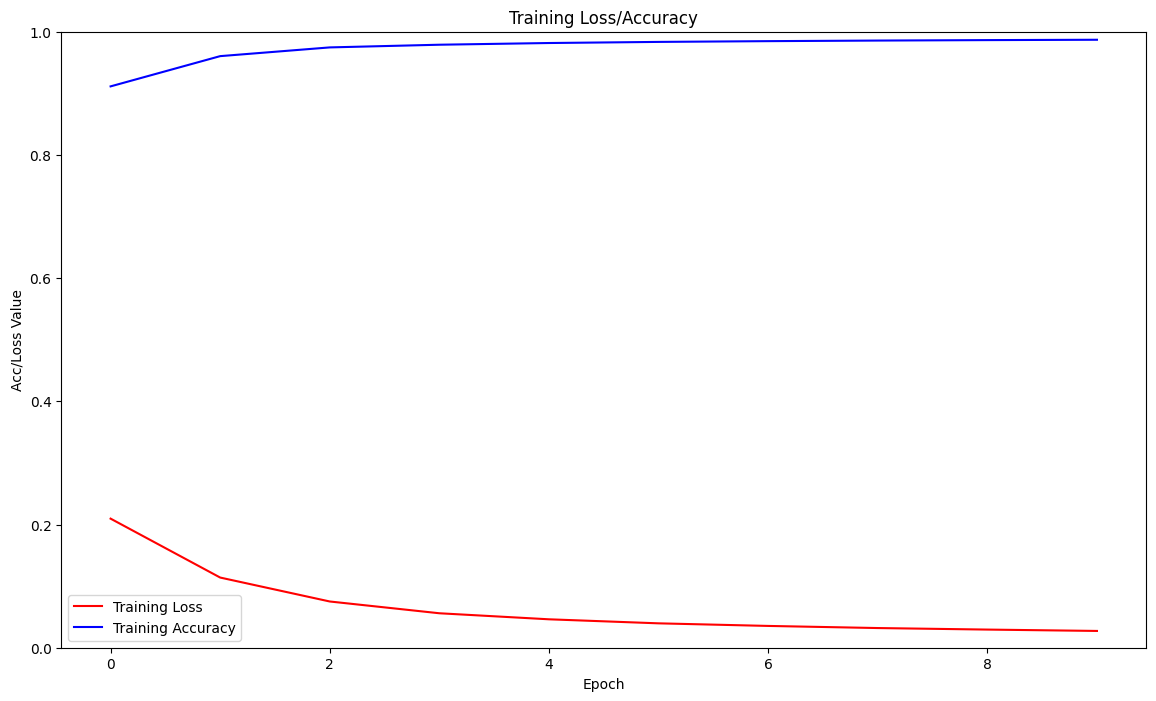

In [38]:
loss = model_history.history['loss']
acc = model_history.history['accuracy']

epochs = range(EPOCHS)

plt.figure(figsize=(14, 8))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Training Loss/Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc/Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 2s 18ms/step


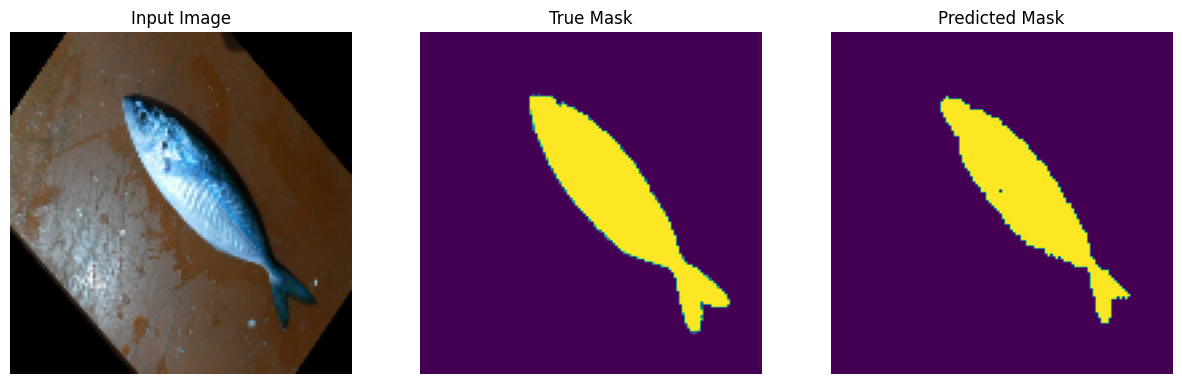

2/2 [==============================] - 0s 24ms/step


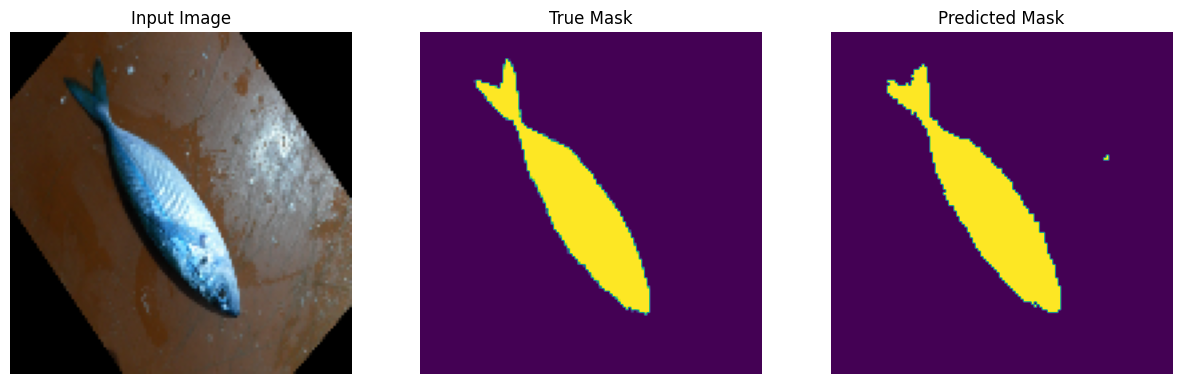

2/2 [==============================] - 0s 24ms/step


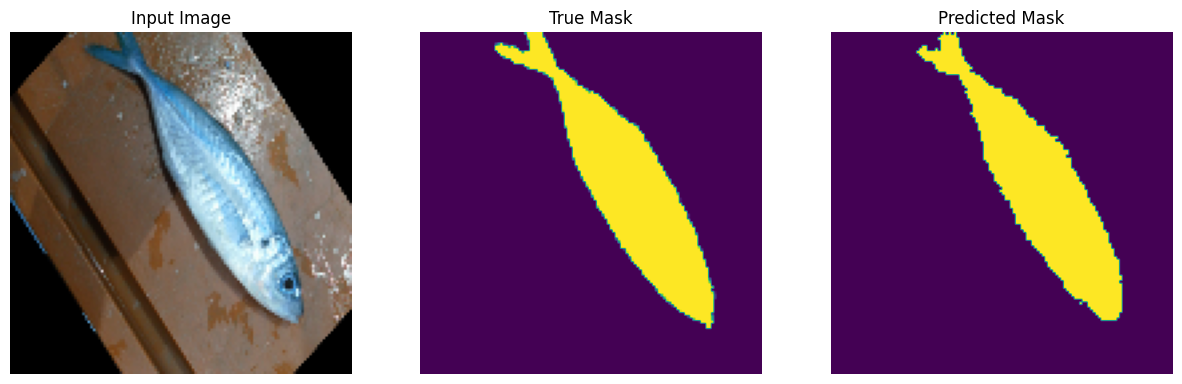

2/2 [==============================] - 0s 32ms/step


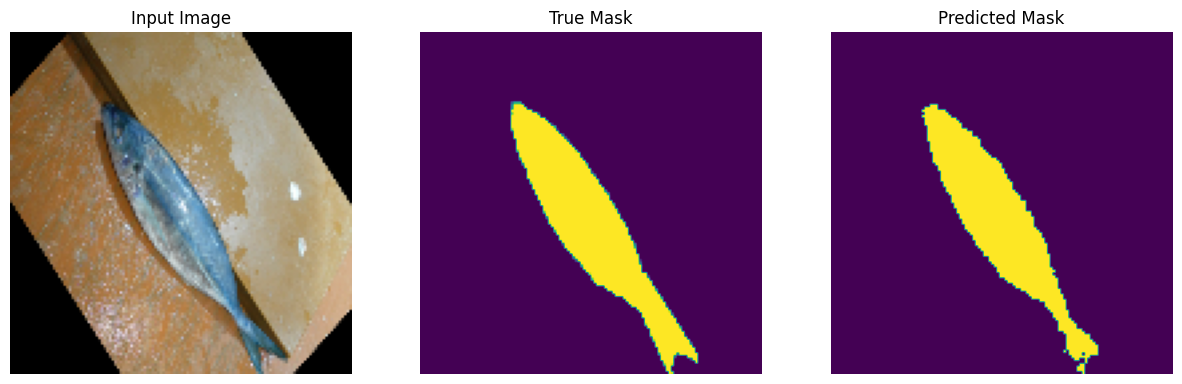

2/2 [==============================] - 1s 1s/step


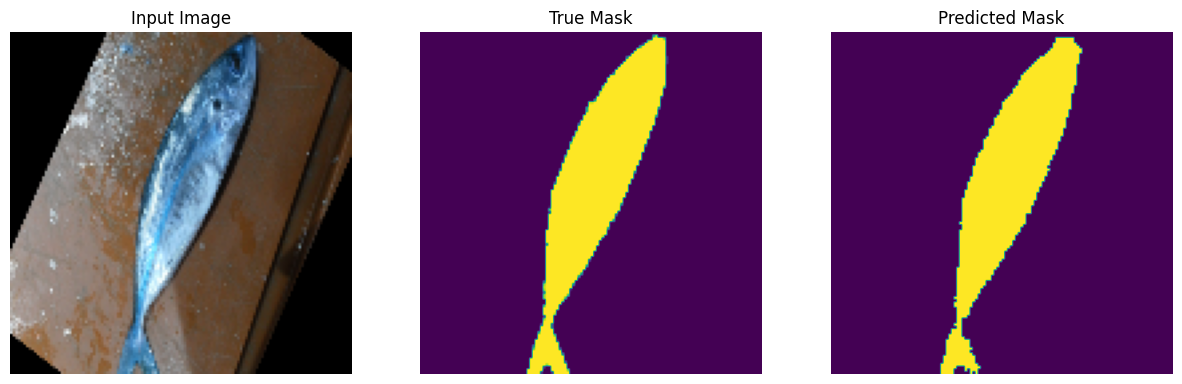

In [39]:
show_predictions(test_dataset, 5)

In [41]:
# Save the model
model.save('fish_segmentation_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [42]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.1 

In [47]:
from tensorflow.keras.models import load_model
model = load_model('fish_segmentation_model.h5')

In [48]:
def predict(image):
  # Preprocess the uploaded image here (resize, normalization etc.) based on your training pipeline
  preprocessed_image = preprocess_image(image)  # Replace with your preprocessing function
  # Make prediction on the preprocessed image
  segmented_image = model.predict(preprocessed_image)
  # Postprocess the predicted mask (convert to RGB, etc.) based on your needs
  postprocessed_mask = postprocess_mask(segmented_image)  # Replace with your postprocessing function
  return postprocessed_mask


In [49]:
interface = gr.Interface(
  fn=predict,
  inputs="image",
  outputs="image",
  title="Fish Segmentation",
  description="Upload an image of a fish and get its segmentation mask."
)

interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0dd24acccb0f1a2163.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
